In [ ]:
# Install required packages (if not available on server)
!pip install getdist
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 778kB 9.6MB/s 
     |████████████████████████████████| 28.5MB 115kB/s 
     |████████████████████████████████| 645kB 47.0MB/s 
  Created wheel for getdist: filename=GetDist-1.3.0-cp37-none-any.whl size=225972 sha256=9038540b53f90264a46deb64e9b1fc0655fc92c07d69328fa4cd199493c083d8
  Stored in directory: /root/.cache/pip/wheels/8c/73/67/12e2eae99bed8bb7420a0e0c01a9754e84d101fc7aca6e0254
Successfully built getdist
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import math
PARSEC = 3.086E15 # (metres)

# Hubble rate 
# Using 1/a = 1+z
# Calulate hubble^-1 becuase when it is integreated later this is the form

Hubble_inv = lambda z, h, om_l, om_m, om_k : 1/(math.sqrt(om_l + om_m*(1+z)**3 + om_k*(1+z)**2))

In [ ]:
from scipy.integrate import quad

c = 2.998E5  # (km/s)
MEGAPARSEC = 3.086E19 # (kilometres)
b=0

def D_l(z, h, om_l, om_m, om_k):
    D_z, D_z_err = integrate.quad(Hubble_inv, 0, z, args=(h, om_l, om_m, om_k))
    
    if om_k > 0:
        return 10e5*(c/(h))*(1+z)*(1/np.sqrt(om_k))*np.sinh(np.sqrt(om_k)*D_z)
    elif om_k < 0:
        return 10e5*(c/(h))*(1+z)*(1/np.sqrt(-om_k))*np.sin(np.sqrt(-om_k)*D_z)
    else:
        return 10e5*(c/h)*(1+z)*D_z                                            # <--- YOUR CODE GOES HERE!

In [ ]:
#distance modulus function
def D_m(h, z, om_l, om_m, om_k):
    return 5*(-1.+np.log10(D_l(h, z, om_l, om_m, om_k)))

In [ ]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [ ]:
# pull out the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
dist_mod = data.T[2] # distance modulus
err_dist_mod = data.T[3] # errors on distance modulus

In [ ]:
# Let's look at the data, just for fun. 
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once
import scipy.integrate as integrate

# luminosity distance in pc
dpc = 10. * 10.**(dist_mod / 5.)

# and in Mpc
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10. * (10.**((dist_mod + err_dist_mod)/5.-6.) - 10.**((dist_mod - err_dist_mod)/5.-6.))

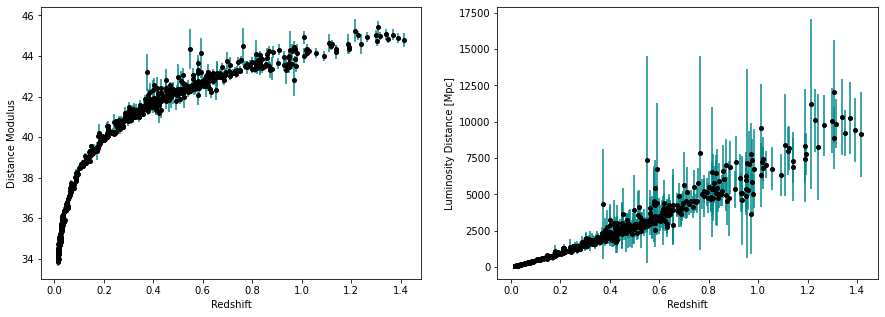

In [ ]:
plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, dist_mod, yerr=err_dist_mod, fmt='o', color='black', ecolor='darkcyan', markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, dMpc, yerr=dMe, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.show()

In [ ]:
# Defining Chi^2 with our variables to test

def chi2_test(h, om_l, om_m, om_k):
    chi2 = 0
    for i in range(len(zs)):
        chi2 += (D_m(zs[i], h, om_l, om_m, om_k) - dist_mod[i])**2 / err_dist_mod[i]**2
    return chi2

In [ ]:
import scipy
from scipy.stats import norm


# Arbitrary starting vaues for our variables, make sure that the omegas sum to 1
h = 50
om_l = 0.5
om_m = 0.4
om_k = 0.1

#Here the convergence values are stored so not to take up space on screen
file = open("convergence_data.csv", "w")
file.write("h,om_l,om_m,om_k\n")

# to store the best parameters
better_value = [np.inf,0,0,0,0]

#This loop dictates 1000 iterations for the testing of the variables also generate normal distributons for each variable
for i in range(1000):
    h_sc = 0.5
    om_l_sc = 0.005
    om_m_sc = 0.005
    om_k_sc = 0.005
    
    # This function calls a random number for each of the variables from the normal gaussian distributions generated earlier
    h_n = np.random.normal(h,h_sc)
    om_l_n = np.random.normal(om_l,om_l_sc)
    om_m_n = np.random.normal(om_m,om_m_sc)
    om_k_n = np.random.normal(om_k,om_k_sc)
    
    # Assigns to r random floats from an interval
    r = np.random.random()
    
    #Everytime there is a lower Chi value it is stored along with the variables that caused it
    if chi2_test(h, om_l, om_m, om_k) < better_value[0]:
        better_value = [chi2_test(h, om_l, om_m, om_k),h, om_l, om_m, om_k]
    
    #np.exp will calculate the exponential of all the elements in the array and then it is checked against r and is done for each variable.
    if r < np.exp((chi2_test(h, om_l, om_m, om_k)-chi2_test(h_n, om_l_n, om_m_n, om_k_n))/2)*(np.random.normal(h_n,h_sc)/np.random.normal(h,h_sc)):
        h = h_n
    if r < np.exp((chi2_test(h, om_l, om_m, om_k)-chi2_test(h_n, om_l_n, om_m_n, om_k_n))/2)*(np.random.normal(om_l_n,om_l_sc)/np.random.normal(om_l,om_l_sc)):
        om_l = om_l_n
    if r < np.exp((chi2_test(h, om_l, om_m, om_k)-chi2_test(h_n, om_l_n, om_m_n, om_k_n))/2)*(np.random.normal(om_m_n,om_m_sc)/np.random.normal(om_m,om_m_sc)):
        om_m = om_m_n
    if r < np.exp((chi2_test(h, om_l, om_m, om_k)-chi2_test(h_n, om_l_n, om_m_n, om_k_n))/2)*(np.random.normal(om_k_n,om_k_sc)/np.random.normal(om_k,om_k_sc)):
        om_k = om_k_n
        
    #Print CSV values into file
    file.write(f"{h},{om_l},{om_m},{om_k}\n")

file.close()
print(better_value)

[562.7715049781341, 66.42261050911507, 0.7055568934850124, 0.2635020156178824, 0.13361553896344663]


In [ ]:
print("Optimum parameters:")
print("CHI^2: ",better_value[0],"\nH0: ", better_value[1],"\nOmega_Lambda: ", better_value[2],"\nOmega_mass: ", better_value[3],"\nOmega_curvature(k): ", better_value[4])

Optimum parameters:
CHI^2:  562.7715049781341 
H0:  66.42261050911507 
Omega_Lambda:  0.7055568934850124 
Omega_mass:  0.2635020156178824 
Omega_curvature(k):  0.13361553896344663


Removed no burn in


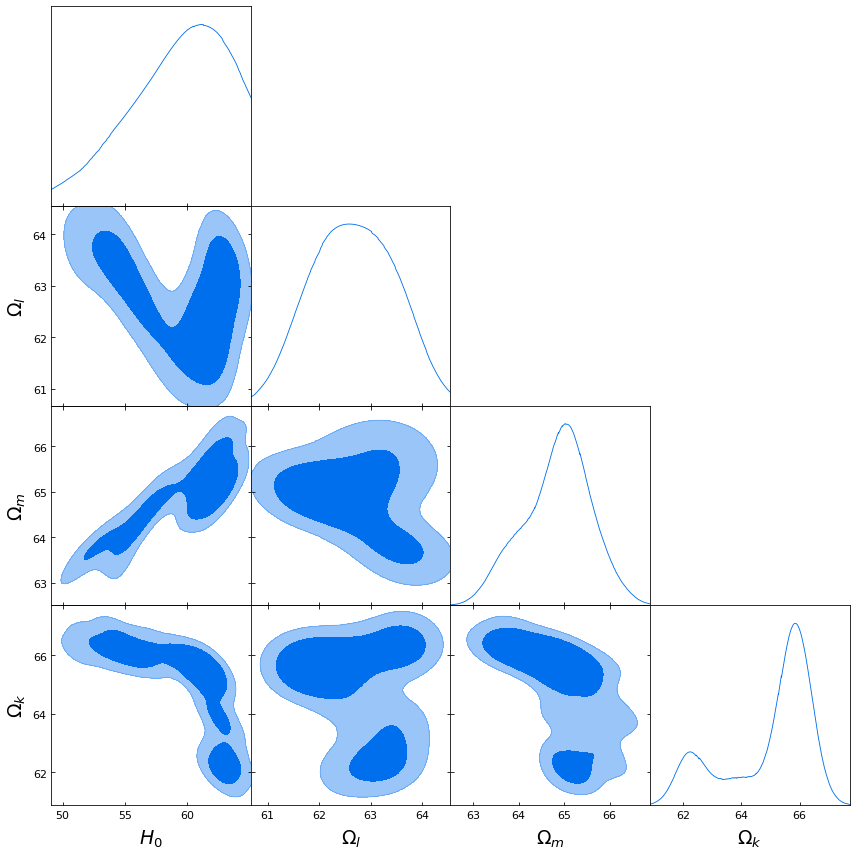

In [ ]:
import getdist, IPython
import pylab
from getdist import plots, MCSamples, loadMCSamples
import numpy as np


#generate data from the csv file recorded
res_data = np.genfromtxt("convergence_data.csv", delimiter=",",skip_header=1)

my_labels = [r'H_0',r'\Omega_l',r'\Omega_m',r'\Omega_k']
my_names = [r'H_0',r'\Omega_l',r'\Omega_m',r'\Omega_k']
range_k = {r'\Omega_k':(-0.3,0.3)}

#number of parameters/variables in visual
dimensionality = 4

#Create the samples numpy array
samples = np.array([])
samples = [np.append(samples, res_data[:,i]) for i in range(dimensionality)][0]
    
#reshape the array into suitable shape for Monte Carlo plotting MCSamples function in GetDist
samples = np.transpose(np.reshape(samples,(dimensionality,int(samples.size/dimensionality))))
samples1 = MCSamples(samples = samples, labels = my_labels, names = my_names)

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 20
j.settings.axes_fontsize = 12
j.triangle_plot(samples1, filled = True)

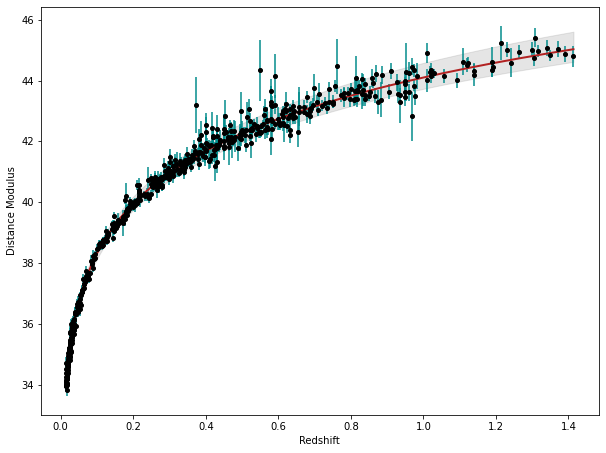

In [ ]:
# example of theoretical curves
SPEED_OF_LIGHT = 299792.458 # in km/s

# Still need to add Omega_k!
def theor_luminosity_distance(z, h, OmegaM, OmegaL):
    return 10.**6 * SPEED_OF_LIGHT / h * (1.+z) * \
    integrate.quad(lambda x: 1. / np.sqrt(OmegaM * (1.+x)**3 + OmegaL), 0., z)[0]

def theor_distance_modulus(z, h, OmegaM, OmegaL):
    return 5. * (-1. + np.log10(theor_luminosity_distance(z, h, OmegaM, OmegaL)))
                 
zsort = sorted(zs)
d_best_fit, d_min, d_max = [], [], []

# YOUR RESULTS GO HERE!
for z in zsort:
    d_best_fit.append(theor_distance_modulus(z, 70., 0.3, 0.7))
    d_min.append(theor_distance_modulus(z, 75., 0.5, 0.5))
    d_max.append(theor_distance_modulus(z, 65., 0.1, 0.9))
    
plt.subplots(figsize=(10, 7.5))
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")

plt.errorbar(zs, dist_mod, yerr=err_dist_mod,\
             fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(zsort, d_best_fit, color='firebrick',linewidth=2.)
plt.fill_between(zsort, d_min, d_max, color='grey', alpha=.2)
plt.show()

The results do not follow the rule of the three omegas summing to 1. if omega k had not been tested for and rather calculated from omega l and m it woud result in a negative number of roughly -0.1. negative universal curvature. It could be done to not calculate omega k, run the tests and then infer it's value from omegak = 1- (omega l + omega m) 